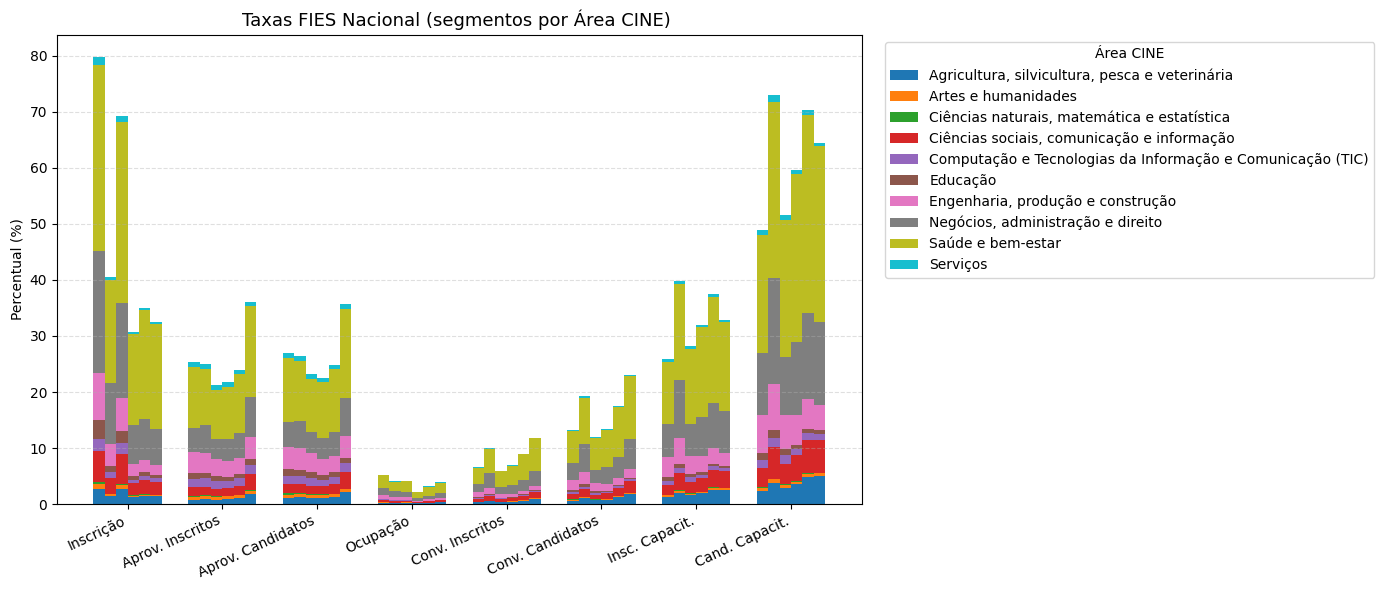

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# caminho do funil bruto (antes de transformar em taxas por região)
path_funil = '../../../planilhas/processado/modulo_3/funil_e_candidatos_unicos/funil_por_regiao.csv'
df = pd.read_csv(path_funil)

# período
df['periodo'] = df['ano'].astype(str) + '.' + df['semestre'].astype(str)

# colunas brutas que já existem no funil
cols_raw = [
    'vagas_fies',
    'Inscritos_Geral',
    'inscritos_com_nota_suficiente',
    'Candidatos_Unicos_Geral',
    'candidatos_unicos_com_nota_suficiente',
    'vagas_ocupadas'
]

# definimos os "pares" (nome_taxa, numerador_col, denominador_col) — denominador é global para a taxa
taxas_info = [
    ('taxa_inscricao', 'Inscritos_Geral', 'vagas_fies'),                      # inscritos / vagas
    ('taxa_aprovacao_por_inscritos', 'inscritos_com_nota_suficiente', 'Inscritos_Geral'),  # inscritos_com_nota / inscritos
    ('taxa_aprovacao_por_candidato', 'candidatos_unicos_com_nota_suficiente', 'Candidatos_Unicos_Geral'),
    ('taxa_ocupacao', 'vagas_ocupadas', 'vagas_fies'),
    ('taxa_conversao_inscritos', 'vagas_ocupadas', 'Inscritos_Geral'),
    ('taxa_conversao_candidatos', 'vagas_ocupadas', 'Candidatos_Unicos_Geral'),
    ('taxa_inscritos_capacitados', 'vagas_ocupadas', 'inscritos_com_nota_suficiente'),
    ('taxa_candidatos_capacitados', 'vagas_ocupadas', 'candidatos_unicos_com_nota_suficiente')
]

# agregamos por período + área (somando os numeradores e denominadores por área)
df_area = df.groupby(['periodo', 'nome_cine_area_geral'], as_index=False)[cols_raw].sum()

# para plot: usaremos apenas um período por vez no exemplo (ou iterar por períodos)
periodos = sorted(df_area['periodo'].unique())
areas = sorted(df_area['nome_cine_area_geral'].unique())

# paleta
cores_areas = plt.cm.tab10(np.linspace(0, 1, len(areas)))

# função que monta os vetores (para um período) para cada taxa: retorna (barra_height, segmentos_por_area)
def calcular_componentes(periodo):
    df_p = df_area[df_area['periodo'] == periodo]
    barra_heights = {}     # taxa nacional por nome_taxa
    segmentos = {}         # dict: nome_taxa -> list of segment values (one per area, in same order 'areas')
    for nome_taxa, numerador_col, denominador_col in taxas_info:
        # denominador nacional é soma do denominador_col em todas as áreas (para aquele período)
        D_nacional = df_p[denominador_col].sum()
        # numeradores por área (mesma ordem 'areas')
        N_areas = []
        for a in areas:
            row = df_p[df_p['nome_cine_area_geral'] == a]
            if row.empty:
                N_areas.append(0.0)
            else:
                N_areas.append(float(row[numerador_col].values[0]))
        N_total = sum(N_areas)
        # evita divisão por zero
        if D_nacional == 0:
            taxa_nacional = 0.0
            segmentos_taxa = [0.0]*len(areas)
        else:
            taxa_nacional = N_total / D_nacional
            segmentos_taxa = [n / D_nacional for n in N_areas]
        barra_heights[nome_taxa] = taxa_nacional * 100.0          # em %
        segmentos[nome_taxa] = [s * 100.0 for s in segmentos_taxa]  # em %
    return barra_heights, segmentos

# Vamos plotar para todos os períodos juntos (cada período terá seu deslocamento)
colunas_taxas = [t[0] for t in taxas_info]
nomes_leg = {
    'taxa_inscricao': 'Inscrição',
    'taxa_aprovacao_por_inscritos': 'Aprov. Inscritos',
    'taxa_aprovacao_por_candidato': 'Aprov. Candidatos',
    'taxa_ocupacao': 'Ocupação',
    'taxa_conversao_inscritos': 'Conv. Inscritos',
    'taxa_conversao_candidatos': 'Conv. Candidatos',
    'taxa_inscritos_capacitados': 'Insc. Capacit.',
    'taxa_candidatos_capacitados': 'Cand. Capacit.'
}

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(colunas_taxas))
largura = 0.12
deslocamentos = np.linspace(-largura* (len(periodos)-1)/2, largura*(len(periodos)-1)/2, len(periodos))

for desloc, periodo in zip(deslocamentos, periodos):
    barra_heights, segmentos = calcular_componentes(periodo)
    base = np.zeros(len(colunas_taxas))
    # para cada área, empilha o segmento para todas as taxas (faz área por área)
    for ia, area in enumerate(areas):
        # coletar, para cada taxa, o segmento desta área
        seg_vals = [segmentos[nome_taxa][ia] for nome_taxa in colunas_taxas]
        ax.bar(x + desloc, seg_vals, width=largura, bottom=base, color=cores_areas[ia], label=area if desloc == deslocamentos[0] else "")
        base += np.array(seg_vals)

# configurar ticks/labels
ax.set_xticks(x)
ax.set_xticklabels([nomes_leg[c] for c in colunas_taxas], rotation=25, ha='right')
ax.set_ylabel('Percentual (%)')
ax.set_title('Taxas FIES Nacional (segmentos por Área CINE) ', fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend(title='Área CINE', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()